In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp

def plot_phaseplane_my_model(
    *,
    m0=0.01,
    lam=10.0,
    alpha=0.0,
    mode="desing",               # "desing" | "frozen" | "frozen_lin"
    U0=0.99,
    P0=-0.01,
    M0=None,
    speeds=None,                 
    rel_speeds=(0.2, 1.0, 2.0),
    T_end=1200.0,
    dt=0.002,
    rtol=1e-9,
    atol=1e-12,
    max_step=0.05,
    figsize=(10.5, 7.0),
    U_lim=(-0.25, 1.25),
    P_lim=(-0.25, 0.05),
    show=True,
    verbose=False,
    tick_labelsize=12,            # tick font size
    # --- Arrow options ---
    arrows="none",                # "none" | "quiver" | "stream" | "traj"
    arrows_top=False,             # also add arrows to the top panel
    quiver_grid=21,               # grid resolution for quiver/stream
    quiver_scale=25,              # scaling for quiver arrows
    arrow_alpha=0.35,             # alpha for quiver/stream
    stream_density=1.2,           # streamline density
    traj_n_arrows=25,             # approx number of arrows per trajectory
    # --- Guides (your "eigenvectors" axes) ---
    show_guides=True              # toggle dashed U-axis (P=0) & P-axis (U=0)
):
    """
    Phase-plane plotter for the desingularised system with optional arrows.

    Guides use your axis eigenvectors: (1,0,0) and (0,1,0) -> U-axis (P=0) and P-axis (U=0).
    """

    # ---------- helpers ----------
    def f_M(m): 
        return alpha*(1.0 - m)

    def format_lambda_latex(val, tol=1e-12):
        """
        Return a LaTeX math snippet for lambda with 10^() style,
        except when lambda is 0, 1, or 10 (printed as-is).
        Examples:
          0 -> "0"
          1 -> "1"
          10 -> "10"
          1000 -> "10^{3}"
          5e-2 -> "5.0\\times 10^{-2}"
          -230 -> "-2.3\\times 10^{2}"
        """
        # exact/simple cases
        if np.isclose(val, 0.0, atol=tol, rtol=0): 
            return "0"
        if np.isclose(val, 1.0, rtol=0, atol=tol):
            return "1"
        if np.isclose(val, 10.0, rtol=0, atol=tol):
            return "10"

        sign = "-" if val < 0 else ""
        av = abs(val)
        exp = int(np.floor(np.log10(av)))
        mant = av / (10**exp)

        # round mantissa to 2 significant figures
        # avoid printing 10.0 due to rounding (e.g., 9.99 -> 10.0)
        mant_rounded = float(f"{mant:.2g}")
        if np.isclose(mant_rounded, 1.0, rtol=0, atol=1e-12):
            # show just 10^{k}
            return f"{sign}10^{{{exp}}}"
        else:
            # show a × 10^{k}
            # keep 2 sig figs; ensure a decimal if not integer-like
            mant_str = f"{mant_rounded:.2g}"
            return f"{sign}{mant_str}\\times 10^{{{exp}}}"

    # ---------- front coefficient and threshold ----------
    D0   = m0*(1.0 - m0)
    cmin = 2.0*np.sqrt(D0)

    # speeds to plot
    if speeds is None:
        speeds = [float(r*cmin) for r in rel_speeds]
    speeds = list(speeds)
    while len(speeds) < 3:
        speeds.append(speeds[-1])

    if M0 is None:
        M0 = m0

    # time grid (ζ)
    t_eval = np.arange(0.0, T_end + dt, dt)

    # ---------- RHS systems ----------
    def rhs_desingularised(zeta, y, c):
        U, P, M = y
        D = M*(1.0 - M)
        dU = P
        dP = -c*P - D*U*(1.0 - U)
        dM = (D/c)*(lam*U*M - f_M(M))
        return [dU, dP, dM]

    def rhs_frozen_nonlinear(zeta, y, c):
        U, P = y
        return [P, -c*P - D0*U*(1.0 - U)]

    def rhs_frozen_linear(zeta, y, c):
        U, P = y
        return [P, -c*P - D0*U]

    # ---------- Figure ----------
    fig = plt.figure(figsize=figsize)
    ax_top = plt.subplot2grid((2,3), (0,0), colspan=3)
    axes   = [plt.subplot2grid((2,3), (1,i)) for i in range(3)]

    # set limits, grid; control only Y ticks (6 of them) + 2dp formatter
    y_ticks = np.linspace(P_lim[0], P_lim[1], 6)
    y_fmt = FormatStrFormatter('%.2f')
    for ax in [ax_top] + axes:
        ax.set_xlim(U_lim)
        ax.set_ylim(P_lim)
        ax.grid(True, ls=":", alpha=0.5)
        ax.set_yticks(y_ticks)
        ax.yaxis.set_major_formatter(y_fmt)
        ax.tick_params(labelsize=tick_labelsize)

    # ---------- Optional dashed guides ----------
    def draw_guides(ax):
        ax.axhline(0.0, ls='--', lw=2.0, color='k', alpha=0.7)    # P=0 (U-axis)
        ax.axvline(0.0, ls='--', lw=2.0, color='0.6', alpha=0.7)  # U=0 (P-axis)

    if show_guides:
        draw_guides(ax_top)
        for ax in axes:
            draw_guides(ax)

    labels = [r"$c<c_{\min}$", r"$c=c_{\min}$", r"$c>c_{\min}$"]
    colors = ["tab:blue", "purple", "tab:orange"]

    # store trajectories if we later want top traj arrows
    top_trajectories = []

    # ---------- Integrations ----------
    for i, (c, lab, col) in enumerate(zip(speeds[:3], labels, colors)):
        if mode == "desing":
            sol = solve_ivp(rhs_desingularised, (0.0, T_end), [U0, P0, M0],
                            args=(c,), t_eval=t_eval, rtol=rtol, atol=atol, max_step=max_step)
            U, P = sol.y[0], sol.y[1]
        elif mode == "frozen":
            sol = solve_ivp(rhs_frozen_nonlinear, (0.0, T_end), [U0, P0],
                            args=(c,), t_eval=t_eval, rtol=rtol, atol=atol, max_step=max_step)
            U, P = sol.y
        else:
            sol = solve_ivp(rhs_frozen_linear, (0.0, T_end), [U0, P0],
                            args=(c,), t_eval=t_eval, rtol=rtol, atol=atol, max_step=max_step)
            U, P = sol.y

        # draw trajectories
        ax_top.plot(U, P, color=col, lw=2.0)
        ax = axes[i]
        ax.plot(U, P, color=col, lw=2.2)

        top_trajectories.append((U, P, col))

        # ---- Arrows on BOTTOM panels if requested ----
        if arrows in ("quiver", "stream"):
            uu = np.linspace(U_lim[0], U_lim[1], quiver_grid)
            pp = np.linspace(P_lim[0], P_lim[1], quiver_grid)
            UU, PP = np.meshgrid(uu, pp)
            # guide field with D ≈ D0 (front-level), keep U(1-U) nonlinearity
            dU = PP
            dP = -c*PP - D0*UU*(1.0 - UU)

            if arrows == "quiver":
                N = np.hypot(dU, dP); N[N == 0] = 1.0
                ax.quiver(UU, PP, dU/N, dP/N, angles='xy',
                          scale_units='xy', scale=quiver_scale, alpha=arrow_alpha, width=0.002)
            else:  # "stream": alpha via RGBA in color tuple
                ax.streamplot(UU, PP, dU, dP, density=stream_density,
                              linewidth=0.8, arrowsize=1.2,
                              color=(0.6, 0.6, 0.6, arrow_alpha))

        elif arrows == "traj":
            # small arrows along the numerical trajectory
            n = len(U)
            if n > 4:
                step = max(2, n // max(1, traj_n_arrows))
                for j in range(step, n - step, step):
                    du, dp = U[j+1] - U[j-1], P[j+1] - P[j-1]
                    ax.annotate("", xy=(U[j], P[j]),
                                xytext=(U[j] - 0.001*du, P[j] - 0.001*dp),
                                arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8, color=col))

    # ---- Arrows on TOP panel if requested ----
    if arrows_top:
        if arrows in ("quiver", "stream"):
            c_top = speeds[1] if len(speeds) >= 2 else speeds[0]
            uu = np.linspace(U_lim[0], U_lim[1], quiver_grid)
            pp = np.linspace(P_lim[0], P_lim[1], quiver_grid)
            UU, PP = np.meshgrid(uu, pp)
            dU = PP
            dP = -c_top*PP - D0*UU*(1.0 - UU)
            if arrows == "quiver":
                N = np.hypot(dU, dP); N[N == 0] = 1.0
                ax_top.quiver(UU, PP, dU/N, dP/N, angles='xy',
                              scale_units='xy', scale=quiver_scale, alpha=arrow_alpha, width=0.002)
            else:
                ax_top.streamplot(UU, PP, dU, dP, density=stream_density,
                                  linewidth=0.8, arrowsize=1.2,
                                  color=(0.6, 0.6, 0.6, arrow_alpha))
        elif arrows == "traj":
            for (U, P, col) in top_trajectories:
                n = len(U)
                if n > 4:
                    step = max(2, n // max(1, traj_n_arrows))
                    for j in range(step, n - step, step):
                        du, dp = U[j+1] - U[j-1], P[j+1] - P[j-1]
                        ax_top.annotate("", xy=(U[j], P[j]),
                                        xytext=(U[j] - 0.001*du, P[j] - 0.001*dp),
                                        arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8, color=col))

    # ---------- Shared labels (slightly lifted/offset) ----------
    fig.supxlabel("U", y=0.07, fontsize=tick_labelsize+4)
    fig.supylabel("P", x=0.02, y=0.60, fontsize=tick_labelsize+4)

    # ---------- Title + subtitle with lambda formatter ----------
    lam_tex = format_lambda_latex(lam)  # formatted string without leading \lambda=
    if np.isclose(alpha, 0.0):
        fig.suptitle(r"$\bf{Phase\ plane\ plot:\ No\ recovery}$", fontsize=20, y=1.02)
        plt.figtext(
            0.5, 0.93,
            rf"$m_0={m0:.2g}$, $\lambda={lam_tex}$",
            ha="center", fontsize=18
        )
    else:
        fig.suptitle(r"$\bf{Phase\ plane\ plot:\ Recovery}$", fontsize=20, y=1.02)
        plt.figtext(
            0.5, 0.93,
            rf"$m_0={m0:.2g}$, $\lambda={lam_tex}$, $\alpha={alpha:.2g}$",
            ha="center", fontsize=18
        )

    # ---------- Optional footer (verbose) ----------
    if verbose:
        sp = ", ".join(f"{c:.4g}" for c in speeds[:3])
        plt.figtext(0.5, 0.015,
                    f"c_min={cmin:.6f} | speeds used: [{sp}] | mode={mode}",
                    ha="center", va="bottom", fontsize=tick_labelsize-1)

    # ---------- Common legend at bottom ----------
    legend_handles = [
        Line2D([0], [0], color=colors[0], lw=2.0),
        Line2D([0], [0], color=colors[1], lw=2.0),
        Line2D([0], [0], color=colors[2], lw=2.0),
    ]
    legend_labels = [labels[0], labels[1], labels[2]]

    if show_guides:
        legend_handles += [
            Line2D([0], [0], color='k',   lw=2.0, ls='--'),
            Line2D([0], [0], color='0.6', lw=2.0, ls='--'),
        ]
        legend_labels += ["guide: U-axis (P=0)", "guide: P-axis (U=0)"]

    ncol = min(5, len(legend_labels))
    fig.legend(
        handles=legend_handles, labels=legend_labels,
        loc="lower center", ncol=ncol, frameon=False, bbox_to_anchor=(0.5, -0.01),
        fontsize=16, handlelength=3, handleheight=1.5
    )

    plt.tight_layout()
    if show:
        plt.subplots_adjust(bottom=0.18)  # room for legend/footer
        plt.show()

    if verbose:
        return fig, (ax_top, axes), {
            "c_min": cmin, "D0": D0, "speeds_used": speeds[:3], "mode": mode
        }

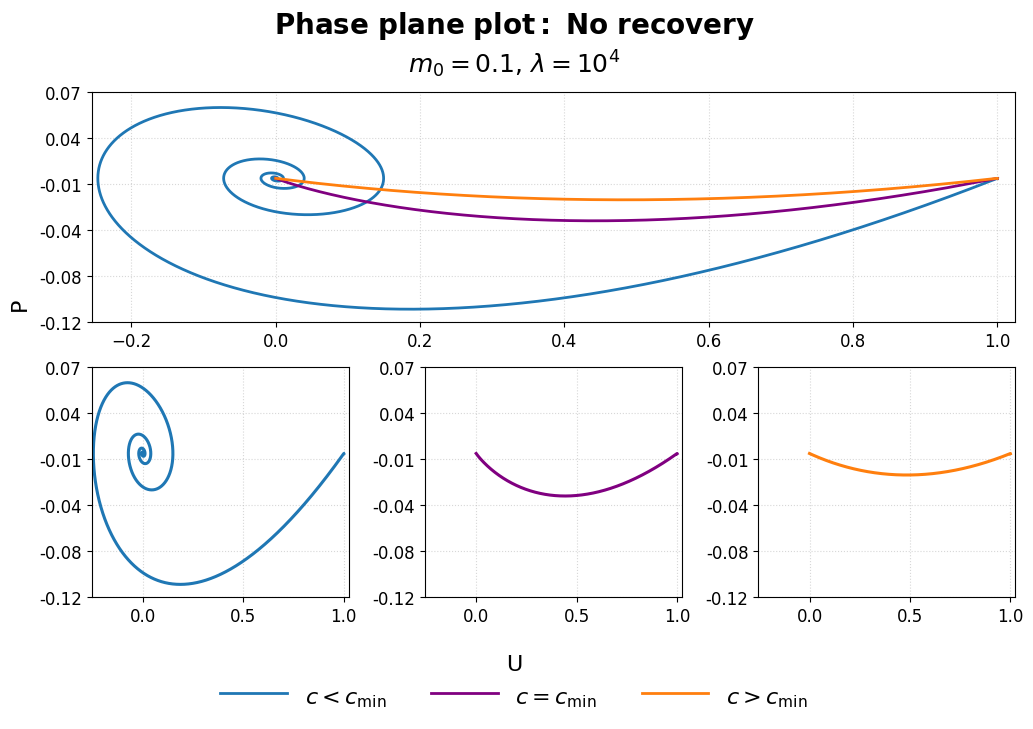

In [136]:
plot_phaseplane_my_model(mode="frozen", m0=0.1, lam=10000, U0 = 1, P0 = -0.0001,
                         U_lim=(-0.255, 1.025), P_lim=(-.125, 0.075), show_guides = False, arrows="none")

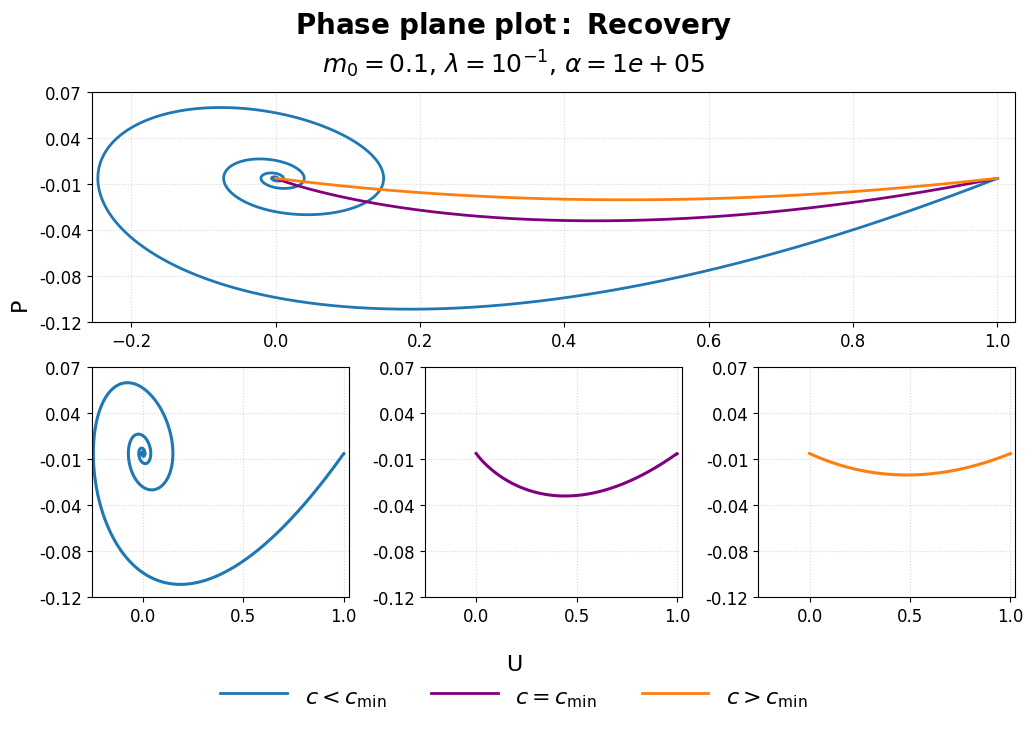

In [118]:
plot_phaseplane_my_model(mode="frozen", m0=0.1, alpha= 100000, lam=0.1, U0 = 1, P0 = -0.0001,
                         U_lim=(-0.255, 1.025), P_lim=(-.125, 0.075), show_guides = False, arrows="none")

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ---------------------------------------
# RHS: desingularised "design" system
# U' = P
# P' = -c P - U(1-U) M(1-M)
# M' = (1/c) M(1-M) (lam*U*M - alpha*(1-M))
# ---------------------------------------
def rhs(z, X, c, lam, alpha):
    U, P, M = X
    D = M * (1.0 - M)
    dU = P
    dP = -c * P - U * (1.0 - U) * D
    dM = (D / c) * (lam * U * M - alpha * (1.0 - M))
    return [dU, dP, dM]

# Event factory: must accept *args because solve_ivp forwards (c,lam,alpha)
def make_stop_event(blowU=5.0, blowP=5.0):
    def event(t, X, *args):
        U, P, M = X
        badM   = (M < -1e-6) or (M > 1.0 + 1e-6)
        blowUP = (not np.isfinite(U)) or (not np.isfinite(P)) or (abs(U) > blowU) or (abs(P) > blowP)
        # Return 0 to stop, positive to continue
        return 0.0 if (badM or blowUP) else 1.0
    event.terminal  = True
    event.direction = 0
    return event

def integrate_and_plot(
    *,
    lam=1.0,
    alpha=0.0,
    m0=0.2,
    U0=0.99, P0=-0.01, M0=None,
    rel_speeds=(0.2, 1.0, 2.0),
    z_end=100.0, dz=0.01,
    rtol=1e-10, atol=1e-12, max_step=5e-3,
    proj=('U','P'),   # ('U','P'), ('U','M'), or ('P','M')
    show=True
):
    if M0 is None:
        M0 = m0

    # c_min = 2*sqrt(m0*(1-m0))
    cmin = 2.0 * np.sqrt(m0 * (1.0 - m0))
    c_list = [cmin * r for r in rel_speeds[:3]]
    labels = [r"$c<c_{\min}$", r"$c=c_{\min}$", r"$c>c_{\min}$"]
    colors = ["tab:blue", "purple", "tab:orange"]

    t_eval = np.arange(0.0, z_end + dz, dz)
    sols   = []
    stop_evt = make_stop_event()

    for c in c_list:
        sol = solve_ivp(
            rhs, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF",
            rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=stop_evt
        )
        sols.append(sol)

    # ---------- Projection plot ----------
    idx = {'U':0, 'P':1, 'M':2}
    i, j = idx[proj[0]], idx[proj[1]]

    plt.figure()
    for sol, col, lab in zip(sols, colors, labels):
        plt.plot(sol.y[i], sol.y[j], lw=2.0, color=col, label=lab)
    plt.grid(True, ls=':', alpha=0.6)
    plt.xlabel(proj[0]); plt.ylabel(proj[1])
    plt.title(f"Projection: {proj[0]} vs {proj[1]}")
    plt.legend()

    # ---------- 3D trajectory ----------
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for sol, col, lab in zip(sols, colors, labels):
        ax.plot(sol.y[0], sol.y[1], sol.y[2], color=col, lw=2.0, label=lab)
    ax.set_xlabel('U'); ax.set_ylabel('P'); ax.set_zlabel('M')
    ax.set_title('3D Trajectories')
    ax.legend(loc='best')

    # ---------- Profiles vs z ----------
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7.5, 7.5))
    names = ['U','P','M']
    for k in range(3):
        axk = axs[k]; axk.grid(True, ls=':', alpha=0.6)
        for sol, col in zip(sols, colors):
            axk.plot(sol.t, sol.y[k], color=col, lw=1.6)
        axk.set_ylabel(names[k])
    axs[-1].set_xlabel('z')
    fig.suptitle(rf"$f(M)=\alpha(1-M)$, $m_0={m0:.2g}$, $\lambda={lam:g}$, $\alpha={alpha:g}$", y=0.97)

    if show:
        plt.tight_layout()
        plt.show()

    return {'cmin': cmin, 'c_list': c_list, 'solutions': sols}

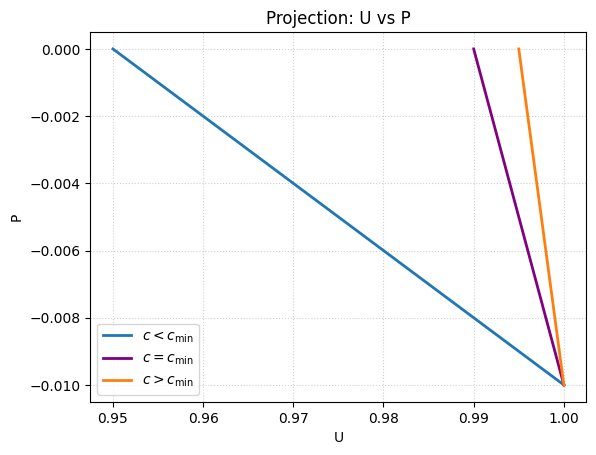

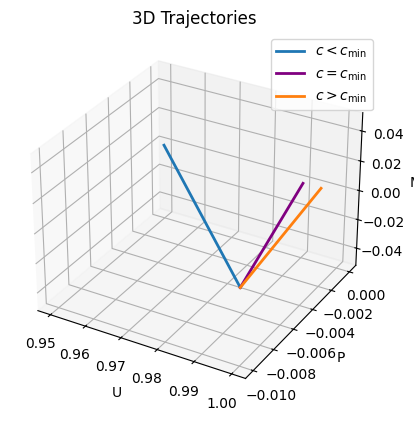

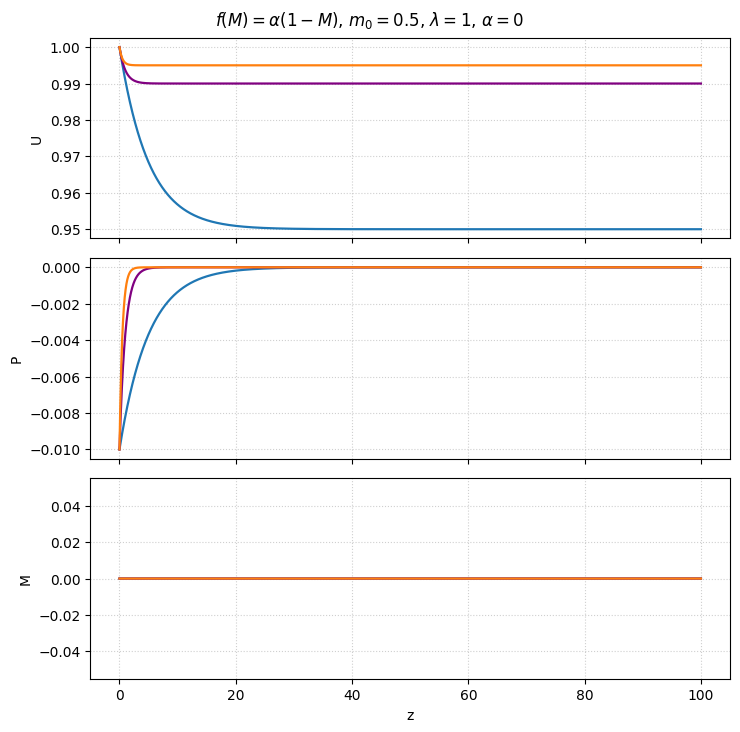

{'cmin': np.float64(1.0),
 'c_list': [np.float64(0.2), np.float64(1.0), np.float64(2.0)],
 'solutions': [  message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 1.000e+00  9.999e-01 ...  9.500e-01  9.500e-01]
              [-1.000e-02 -9.980e-03 ... -2.065e-11 -2.061e-11]
              [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
        sol: None
   t_events: [array([], dtype=float64)]
   y_events: [array([], dtype=float64)]
       nfev: 40022
       njev: 1
        nlu: 2344,
    message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 1.000e+00  9.999e-01 ...  9.900e-01  9.900e-01]
              [-1.000e-02 -9.900e-03 ... -4.242e-46 -4.200e-46]
              [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
    

In [144]:
integrate_and_plot(
        lam=1.0, alpha=0.0, m0=0.5,
        U0=1, P0=-0.01, M0=0,
        rel_speeds=(0.2, 1.0, 2.0),
        z_end=100.0, dz=0.01,
        rtol=1e-10, atol=1e-12, max_step=5e-3,
        proj=('U','P')   # change to ('U','M') or ('P','M') to re-project
    )

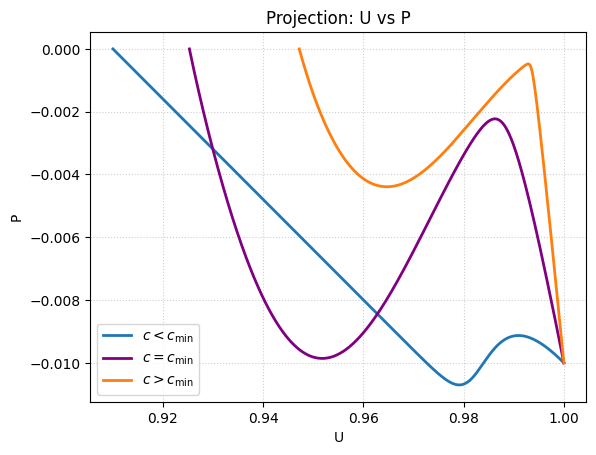

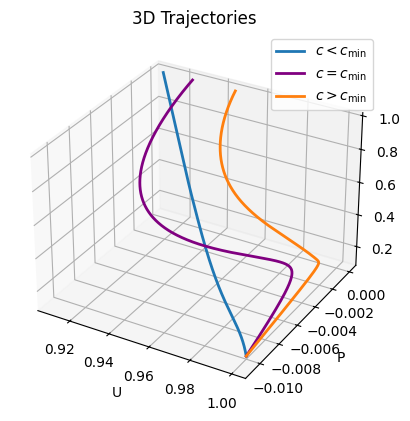

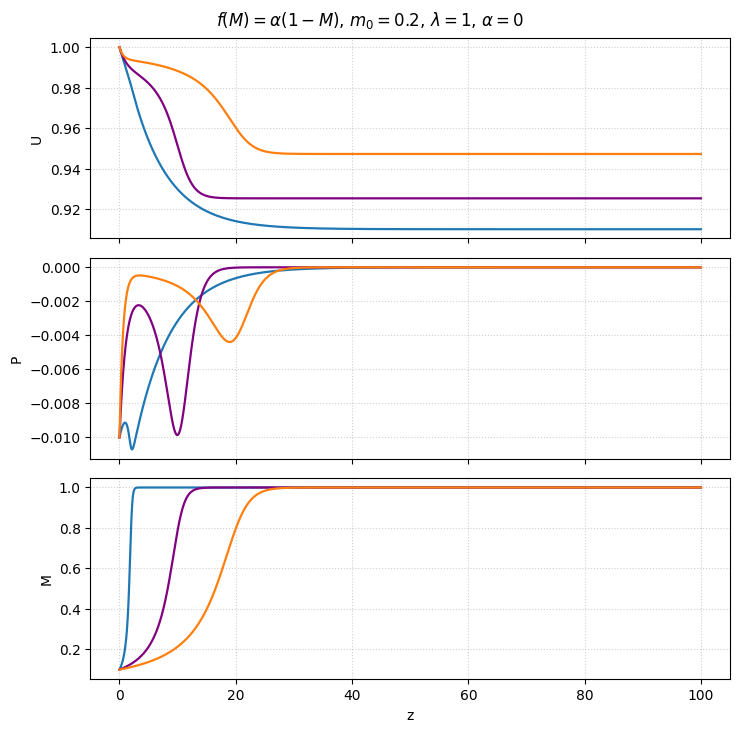

{'cmin': np.float64(0.8),
 'c_list': [np.float64(0.16000000000000003), np.float64(0.8), np.float64(1.6)],
 'solutions': [  message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 1.000e+00  9.999e-01 ...  9.100e-01  9.100e-01]
              [-1.000e-02 -9.984e-03 ... -1.763e-09 -1.761e-09]
              [ 1.000e-01  1.006e-01 ...  1.000e+00  1.000e+00]]
        sol: None
   t_events: [array([], dtype=float64)]
   y_events: [array([], dtype=float64)]
       nfev: 40108
       njev: 1
        nlu: 2336,
    message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 1.000e+00  9.999e-01 ...  9.253e-01  9.253e-01]
              [-1.000e-02 -9.920e-03 ... -8.251e-16 -8.251e-16]
              [ 1.000e-01  1.001e-01 ...  1.000e+00  

In [143]:
integrate_and_plot(
        lam=1.0, alpha=0.0, m0=0.2,
        U0=1, P0=-0.01, M0=m0,
        rel_speeds=(0.2, 1.0, 2.0),
        z_end=100.0, dz=0.01,
        rtol=1e-10, atol=1e-12, max_step=5e-3,
        proj=('U','P')   # change to ('U','M') or ('P','M') to re-project
    )

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# =========================
# DESIGN system (y = [U,P,M])
# =========================
def rhs_design(z, X, c, lam, alpha):
    U, P, M = X
    D = M * (1.0 - M)
    dU = P
    dP = -c * P - U * (1.0 - U) * D
    dM = (D / c) * (lam * U * M - alpha * (1.0 - M))
    return [dU, dP, dM]

def make_stop_event_generic(blowU=5.0, blowP=5.0):
    def event(t, X, *args):
        U, P, M = X
        badM   = (M < -1e-6) or (M > 1.0 + 1e-6)
        blowUP = (not np.isfinite(U)) or (not np.isfinite(P)) or (abs(U) > blowU) or (abs(P) > blowP)
        return 0.0 if (badM or blowUP) else 1.0
    event.terminal  = True
    event.direction = 0
    return event

def integrate_and_plot(
    *, lam=1.0, alpha=0.0, m0=0.2,
    U0=0.99, P0=-0.01, M0=None,
    rel_speeds=(0.2, 1.0, 2.0),
    z_end=100.0, dz=0.01,
    rtol=1e-10, atol=1e-12, max_step=5e-3,
    proj=('U','P'), show=True
):
    if M0 is None:
        M0 = m0
    cmin = 2.0*np.sqrt(m0*(1.0-m0))
    c_list = [cmin*r for r in rel_speeds[:3]]
    labels = [r"$c<c_{\min}$", r"$c=c_{\min}$", r"$c>c_{\min}$"]
    colors = ["tab:blue","purple","tab:orange"]
    t_eval = np.arange(0.0, z_end+dz, dz)
    stop_evt = make_stop_event_generic()

    sols = []
    for c in c_list:
        sol = solve_ivp(
            rhs_design, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=stop_evt
        )
        sols.append(sol)

    # Projection
    idx = {'U':0,'P':1,'M':2}
    i,j = idx[proj[0]], idx[proj[1]]
    plt.figure()
    for sol,col,lab in zip(sols, colors, labels):
        plt.plot(sol.y[i], sol.y[j], lw=2.0, color=col, label=lab)
    plt.grid(True, ls=':'); plt.xlabel(proj[0]); plt.ylabel(proj[1])
    plt.title("DESIGN: projection {} vs {}".format(*proj)); plt.legend()

    # 3D
    from mpl_toolkits.mplot3d import Axes3D  # noqa
    fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')
    for sol,col,lab in zip(sols, colors, labels):
        ax.plot(sol.y[0], sol.y[1], sol.y[2], color=col, lw=2.0, label=lab)
    ax.set_xlabel('U'); ax.set_ylabel('P'); ax.set_zlabel('M')
    ax.set_title('DESIGN: 3D trajectories'); ax.legend()

    # Profiles
    fig,axs = plt.subplots(3,1,sharex=True, figsize=(7.5,7.5))
    names=['U','P','M']
    for k in range(3):
        for sol,col in zip(sols, colors):
            axs[k].plot(sol.t, sol.y[k], color=col, lw=1.6)
        axs[k].set_ylabel(names[k]); axs[k].grid(True, ls=':')
    axs[-1].set_xlabel('z')
    fig.suptitle(rf"DESIGN  $m_0={m0:.2g}$, $\lambda={lam:g}$, $\alpha={alpha:g}$", y=0.97)
    if show: plt.tight_layout(); plt.show()
    return {'cmin': cmin, 'c_list': c_list, 'solutions': sols}

# =========================
# CROSSLEY system (y = [U,V,M])
# =========================
def rhs_crossley(z, X, c, lam):
    U, V, M = X
    denom = max(1.0 - M, 1e-10)  # guard 1/(1-M)
    dU = V
    dV = (-c*V - (lam/c)*M*U*V - (lam**2/c**2)*M*U**3 - U*(1.0 - U - M)) / denom
    dM = (lam/c) * M * U
    return [dU, dV, dM]

def make_stop_event_crossley(eps=1e-6, blowU=5.0, blowV=5.0):
    def event(t, X, *args):
        U, V, M = X
        near_sing = (M > 1.0 - eps)  # avoid 1/(1-M) blow-up
        blowUP = (not np.isfinite(U)) or (not np.isfinite(V)) or (abs(U)>blowU) or (abs(V)>blowV)
        return 0.0 if (near_sing or blowUP) else 1.0
    event.terminal  = True
    event.direction = 0
    return event

def integrate_and_plot_crossley(
    *, lam=1.0, m0=0.01,
    U0=0.9, V0=-0.01, M0=None,
    speeds=None, z_end=100.0, dz=0.01,
    rtol=1e-12, atol=1e-15, max_step=5e-3,
    proj=('U','V'), show=True
):
    if M0 is None:
        M0 = m0
    # paper's c set: {1, 2(1-m0), 3}
    if speeds is None:
        speeds = [1.0, 2.0*(1.0 - m0), 3.0]
    labels = [r"$c<c_{\min}$", r"$c=c_{\min}$", r"$c>c_{\min}$"]
    colors = ["tab:blue","purple","tab:orange"]
    t_eval = np.arange(0.0, z_end+dz, dz)
    stop_evt = make_stop_event_crossley()

    sols = []
    for c in speeds[:3]:
        sol = solve_ivp(
            rhs_crossley, (0.0, z_end), [U0, V0, M0],
            args=(c, lam),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=stop_evt
        )
        sols.append(sol)

    # Projection
    idx={'U':0,'V':1,'M':2}; i,j = idx[proj[0]], idx[proj[1]]
    plt.figure()
    for sol,col,lab in zip(sols, colors, labels):
        plt.plot(sol.y[i], sol.y[j], lw=2.0, color=col, label=lab)
    plt.grid(True, ls=':'); plt.xlabel(proj[0]); plt.ylabel(proj[1])
    plt.title("CROSSLEY: projection {} vs {}".format(*proj)); plt.legend()

    # 3D
    from mpl_toolkits.mplot3d import Axes3D  # noqa
    fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')
    for sol,col,lab in zip(sols, colors, labels):
        ax.plot(sol.y[0], sol.y[1], sol.y[2], color=col, lw=2.0, label=lab)
    ax.set_xlabel('U'); ax.set_ylabel('V'); ax.set_zlabel('M')
    ax.set_title('CROSSLEY: 3D trajectories'); ax.legend()

    # Profiles
    fig,axs = plt.subplots(3,1,sharex=True, figsize=(7.5,7.5))
    names=['U','V','M']
    for k in range(3):
        for sol,col in zip(sols, colors):
            axs[k].plot(sol.t, sol.y[k], color=col, lw=1.6)
        axs[k].set_ylabel(names[k]); axs[k].grid(True, ls=':')
    axs[-1].set_xlabel('z')
    fig.suptitle(rf"CROSSLEY  $m_0={m0:.2g}$, $\lambda={lam:g}$", y=0.97)
    if show: plt.tight_layout(); plt.show()
    return {'speeds': speeds[:3], 'solutions': sols}

    

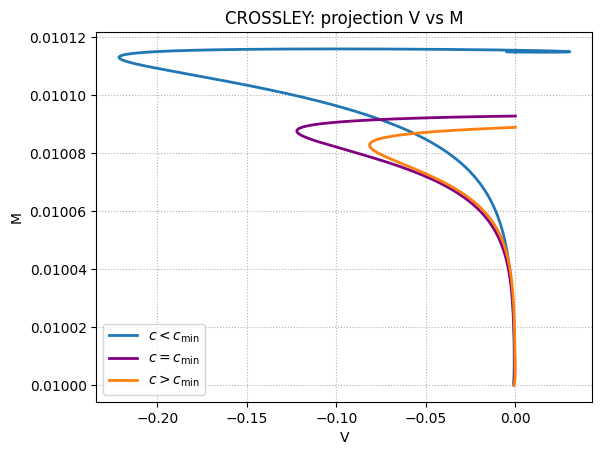

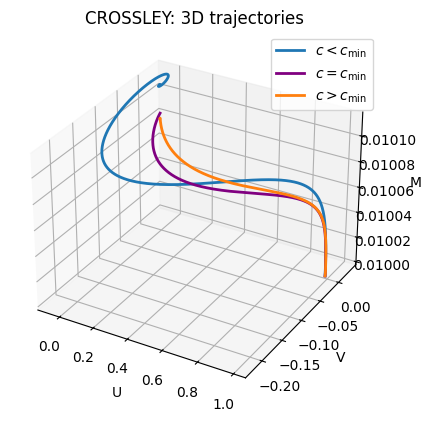

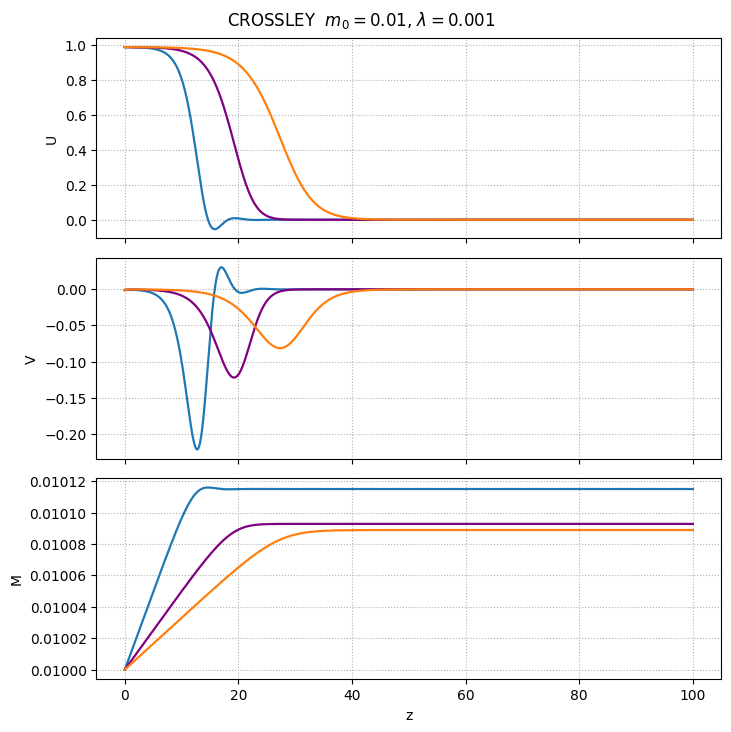

{'speeds': [1.0, 1.98, 3.0],
 'solutions': [  message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 9.900e-01  9.900e-01 ...  2.182e-20  2.173e-20]
              [-1.000e-03 -9.900e-04 ... -9.133e-21 -9.258e-21]
              [ 1.000e-02  1.000e-02 ...  1.011e-02  1.011e-02]]
        sol: None
   t_events: [array([], dtype=float64)]
   y_events: [array([], dtype=float64)]
       nfev: 20926
       njev: 1
        nlu: 960,
    message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 9.900e-01  9.900e-01 ...  1.976e-33  1.957e-33]
              [-1.000e-03 -9.802e-04 ... -1.942e-33 -1.923e-33]
              [ 1.000e-02  1.000e-02 ...  1.009e-02  1.009e-02]]
        sol: None
   t_events: [array([], dtype=float64)]
   y_eve

In [205]:
# Crossley figure-style run (matches the caption)
integrate_and_plot_crossley(
    lam=.001, m0=0.01,
    U0=.99, V0=-0.001, M0=0.01,
    speeds=[1.0, 2.0*(1.0 - 0.01), 3.0],  # {c, 2(1-m0), 3}
    z_end=100.0, dz=0.01,
    rtol=1e-15, atol=1e-15, max_step=0.01,  # tight tol, step like τ=0.01
    proj=('V','M')
)

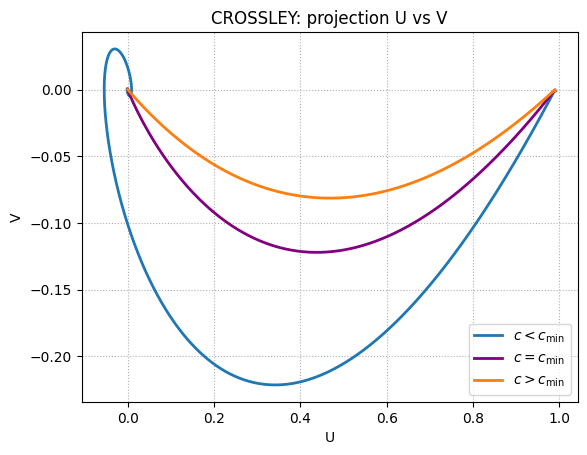

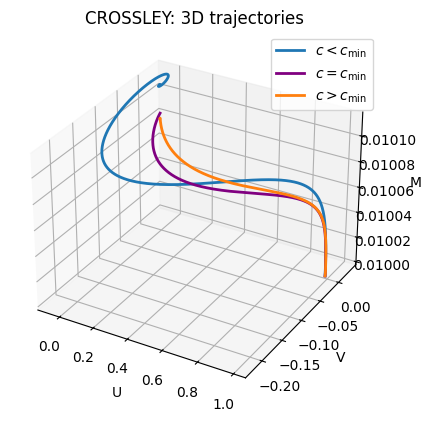

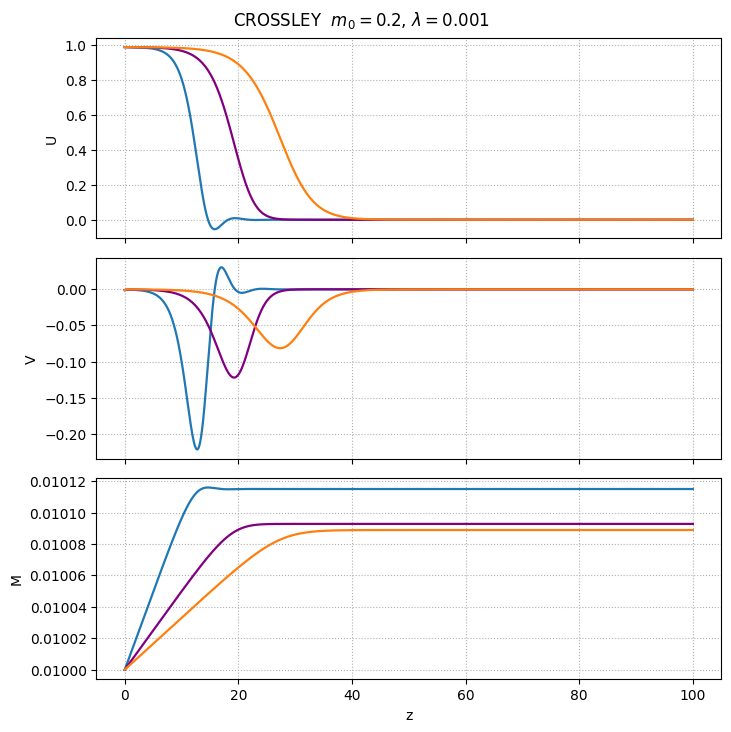

{'speeds': [1.0, 1.98, 3.0],
 'solutions': [  message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 9.900e-01  9.900e-01 ...  2.182e-20  2.173e-20]
              [-1.000e-03 -9.900e-04 ... -9.133e-21 -9.258e-21]
              [ 1.000e-02  1.000e-02 ...  1.011e-02  1.011e-02]]
        sol: None
   t_events: [array([], dtype=float64)]
   y_events: [array([], dtype=float64)]
       nfev: 20926
       njev: 1
        nlu: 960,
    message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 9.900e-01  9.900e-01 ...  1.976e-33  1.957e-33]
              [-1.000e-03 -9.802e-04 ... -1.942e-33 -1.923e-33]
              [ 1.000e-02  1.000e-02 ...  1.009e-02  1.009e-02]]
        sol: None
   t_events: [array([], dtype=float64)]
   y_eve

In [206]:
# Crossley figure-style run (matches the caption)
integrate_and_plot_crossley(
    lam=.001, m0=0.2,
    U0=.99, V0=-0.001, M0=0.01,
    speeds=[1.0, 2.0*(1.0 - 0.01), 3.0],  # {c, 2(1-m0), 3}
    z_end=100.0, dz=0.01,
    rtol=1e-15, atol=1e-15, max_step=0.01,  # tight tol, step like τ=0.01
    proj=('U','V')
)

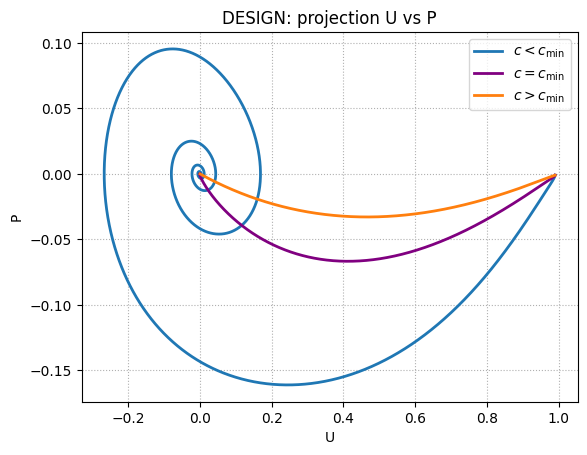

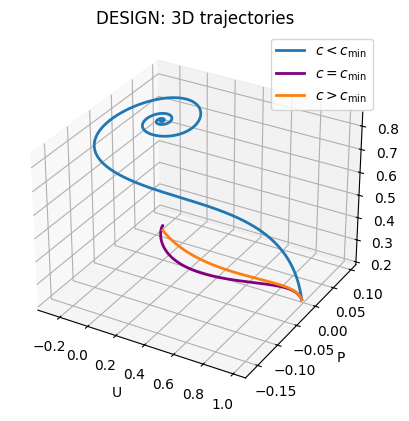

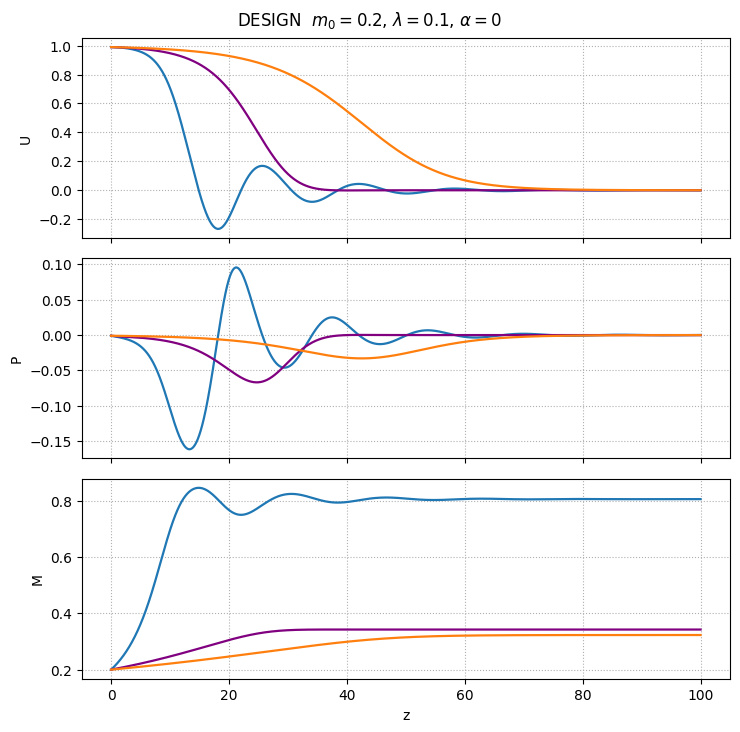

{'cmin': np.float64(0.8),
 'c_list': [np.float64(0.16000000000000003), np.float64(0.8), np.float64(1.6)],
 'solutions': [  message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 9.900e-01  9.900e-01 ... -4.157e-04 -4.150e-04]
              [-1.000e-03 -1.014e-03 ...  7.395e-05  7.448e-05]
              [ 2.000e-01  2.002e-01 ...  8.056e-01  8.056e-01]]
        sol: None
   t_events: [array([], dtype=float64)]
   y_events: [array([], dtype=float64)]
       nfev: 20056
       njev: 1
        nlu: 779,
    message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 9.900e-01  9.900e-01 ...  1.270e-14  1.285e-14]
              [-1.000e-03 -1.008e-03 ...  1.475e-14  1.460e-14]
              [ 2.000e-01  2.000e-01 ...  3.424e-01  3

In [207]:
# Design-system figure-style run (alpha = 0)
integrate_and_plot(
    lam=0.1, alpha=0.0, m0=0.2,
    U0=0.99, P0=-0.001, M0=0.2,
    rel_speeds=(0.2, 1.0, 2.0),   # scales of c_min (design system definition)
    z_end=100.0, dz=0.01,
    rtol=1e-15, atol=1e-15, max_step=0.01,
    proj=('U','P')   # in design system the momentum variable is P, not V
)

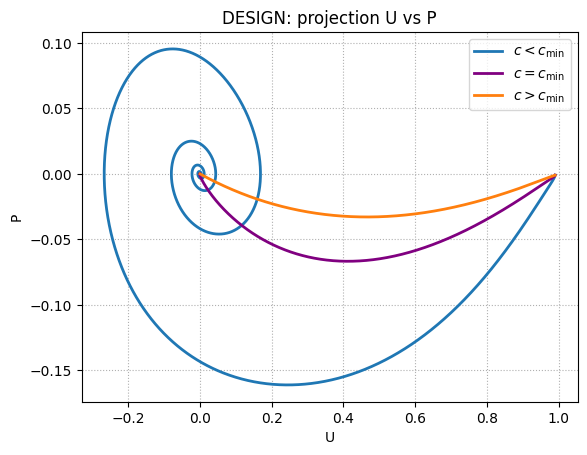

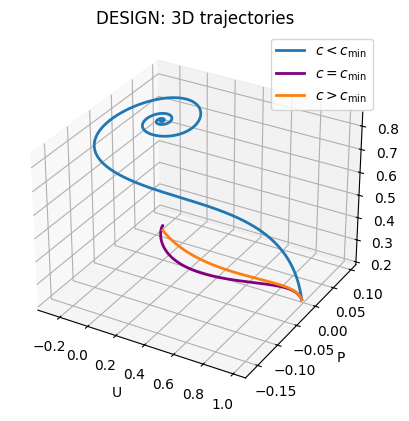

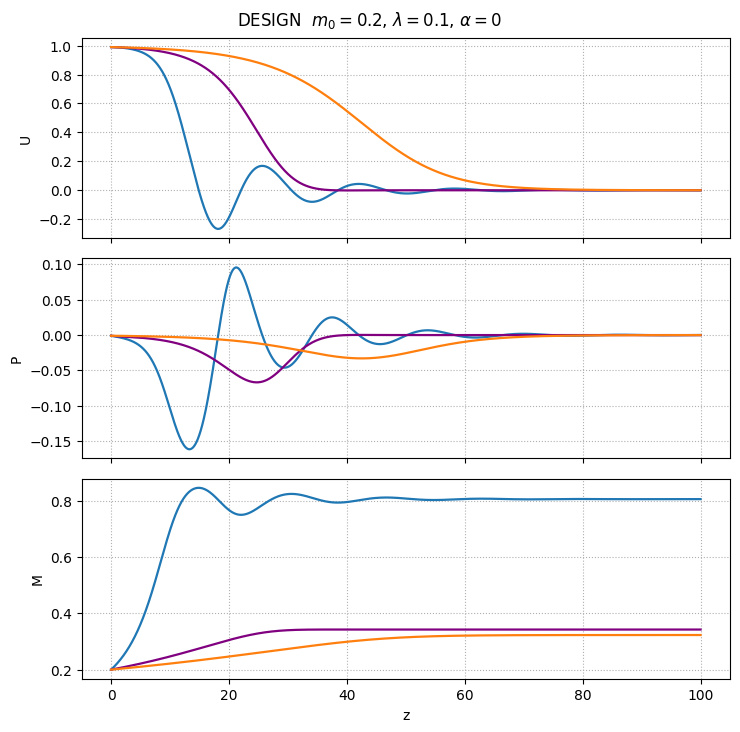

{'cmin': np.float64(0.8),
 'c_list': [np.float64(0.16000000000000003), np.float64(0.8), np.float64(1.6)],
 'solutions': [  message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 9.900e-01  9.900e-01 ... -4.157e-04 -4.150e-04]
              [-1.000e-03 -1.014e-03 ...  7.395e-05  7.448e-05]
              [ 2.000e-01  2.002e-01 ...  8.056e-01  8.056e-01]]
        sol: None
   t_events: [array([], dtype=float64)]
   y_events: [array([], dtype=float64)]
       nfev: 20056
       njev: 1
        nlu: 779,
    message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 9.900e-01  9.900e-01 ...  1.270e-14  1.285e-14]
              [-1.000e-03 -1.008e-03 ...  1.475e-14  1.460e-14]
              [ 2.000e-01  2.000e-01 ...  3.424e-01  3

In [208]:
# Design-system figure-style run (alpha = 0)
integrate_and_plot(
    lam=0.1, alpha=0.0, m0=0.2,
    U0=0.99, P0=-0.001, M0=0.2,
    rel_speeds=(0.2, 1.0, 2.0),   # scales of c_min (design system definition)
    z_end=100.0, dz=0.01,
    rtol=1e-15, atol=1e-15, max_step=0.01,
    proj=('U','P')   # in design system the momentum variable is P, not V
)

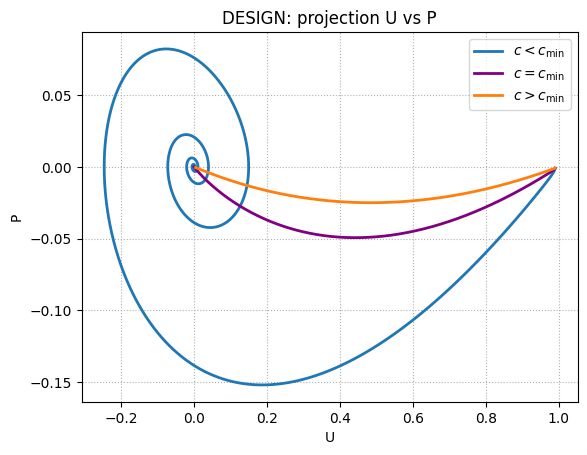

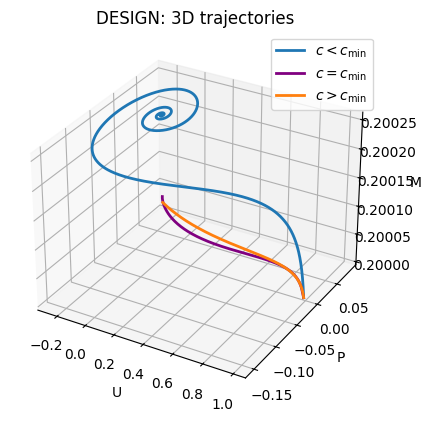

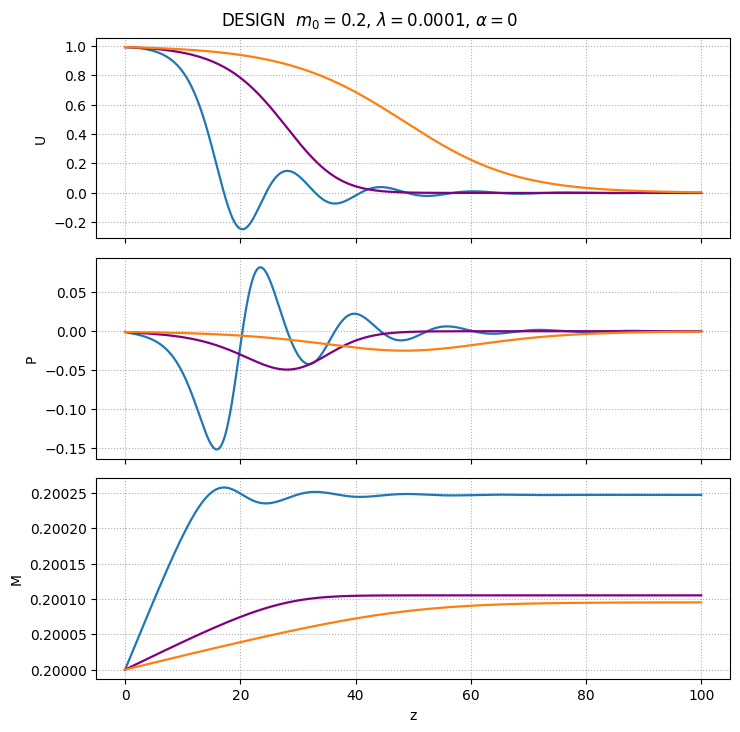

{'cmin': np.float64(0.8),
 'c_list': [np.float64(0.16000000000000003), np.float64(0.8), np.float64(1.6)],
 'solutions': [  message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 9.900e-01  9.900e-01 ... -4.305e-04 -4.308e-04]
              [-1.000e-03 -1.014e-03 ... -3.565e-05 -3.491e-05]
              [ 2.000e-01  2.000e-01 ...  2.002e-01  2.002e-01]]
        sol: None
   t_events: [array([], dtype=float64)]
   y_events: [array([], dtype=float64)]
       nfev: 20054
       njev: 1
        nlu: 778,
    message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 9.900e-01  9.900e-01 ...  1.798e-11  1.791e-11]
              [-1.000e-03 -1.008e-03 ... -6.940e-12 -6.914e-12]
              [ 2.000e-01  2.000e-01 ...  2.001e-01  2

In [209]:
# Design-system figure-style run (alpha = 0)
integrate_and_plot(
    lam=0.0001, alpha=0.0, m0=0.2,
    U0=0.99, P0=-0.001, M0=0.2,
    rel_speeds=(0.2, 1.0, 2.0),   # scales of c_min (design system definition)
    z_end=100.0, dz=0.01,
    rtol=1e-15, atol=1e-15, max_step=0.01,
    proj=('U','P')   # in design system the momentum variable is P, not V
)

In [222]:
def integrate_and_plot(
    *, lam=0.1, alpha=0.0, m0=0.2,
    U0=0.99, P0=-0.001, M0=0.2,
    rel_speeds=(0.2, 1.0, 2.0),
    z_end=100.0, dz=0.01,
    rtol=1e-15, atol=1e-15, max_step=0.01,
    proj=('U','P'), show=True
):
    if M0 is None:
        M0 = m0

    # --- speeds ---
    cmin   = 2.0*np.sqrt(m0*(1.0-m0))
    c_list = [cmin*r for r in rel_speeds[:3]]
    labels = [r"$c<c_{\min}$", r"$c=c_{\min}$", r"$c>c_{\min}$"]
    colors = ["tab:blue","purple","tab:orange"]

    # --- integrate ---
    t_eval   = np.arange(0.0, z_end+dz, dz)
    stop_evt = make_stop_event_generic()
    sols = []
    for c in c_list:
        sol = solve_ivp(
            rhs_design, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=stop_evt
        )
        sols.append(sol)

    # =========================
    # Projection (styled)
    # =========================
    # Bigger global fonts (you can tweak numbers)
    plt.rcParams.update({
        "font.size": 16,
        "axes.titlesize": 22,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 14
    })

    idx = {'U':0,'P':1,'M':2}
    i, j = idx[proj[0]], idx[proj[1]]

    # Wide figure, not too tall
    fig, ax = plt.subplots(figsize=(12, 3.6))

    for sol, col, lab in zip(sols, colors, labels):
        ax.plot(sol.y[i], sol.y[j], lw=2.0, color=col, label=lab)

    ax.grid(True, ls=':')
    ax.set_xlabel(proj[0])
    ax.set_ylabel(proj[1])

    # Title + smaller subtitle
        # Title + subtitle
    ax.set_title("Phase–space projection", fontweight='bold',pad=28)
    ax.text(
        0.5, 1.02,
        rf"No regeneration: $m_0={m0:.2g}$, $\lambda={lam:g}$",
        transform=ax.transAxes, ha="center", va="bottom", fontsize=13
    )

    # Bigger tick marks
    ax.tick_params(axis='both', which='both', length=5, width=1)

    # Legend outside (right), reserve space with tight_layout rect
    leg = ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)
    fig.tight_layout(rect=[0.0, 0.0, 0.82, 1.0])

    # =========================
    # (optional) keep your 3D and profiles as-is
    # =========================
    if show:
        plt.show()

    return {'cmin': cmin, 'c_list': c_list, 'solutions': sols}

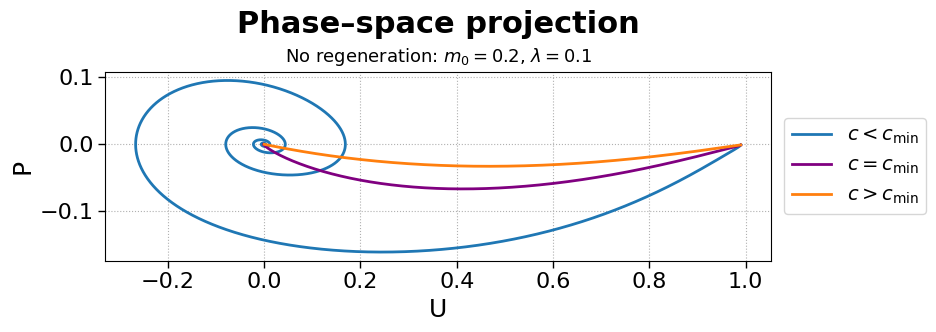

{'cmin': np.float64(0.8),
 'c_list': [np.float64(0.16000000000000003), np.float64(0.8), np.float64(1.6)],
 'solutions': [  message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 9.900e-01  9.900e-01 ... -4.157e-04 -4.150e-04]
              [-1.000e-03 -1.014e-03 ...  7.395e-05  7.448e-05]
              [ 2.000e-01  2.002e-01 ...  8.056e-01  8.056e-01]]
        sol: None
   t_events: [array([], dtype=float64)]
   y_events: [array([], dtype=float64)]
       nfev: 20056
       njev: 1
        nlu: 779,
    message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  9.999e+01  1.000e+02]
          y: [[ 9.900e-01  9.900e-01 ...  1.270e-14  1.285e-14]
              [-1.000e-03 -1.008e-03 ...  1.475e-14  1.460e-14]
              [ 2.000e-01  2.000e-01 ...  3.424e-01  3

In [223]:
integrate_and_plot(
    lam=0.1, alpha=0.0, m0=0.2,
    U0=0.99, P0=-0.001, M0=0.2,
    rel_speeds=(0.2, 1.0, 2.0),
    z_end=100.0, dz=0.01,
    rtol=1e-15, atol=1e-15, max_step=0.01,
    proj=('U','P')
)

/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_60780/2283768349.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.04, 0.86, 0.94])


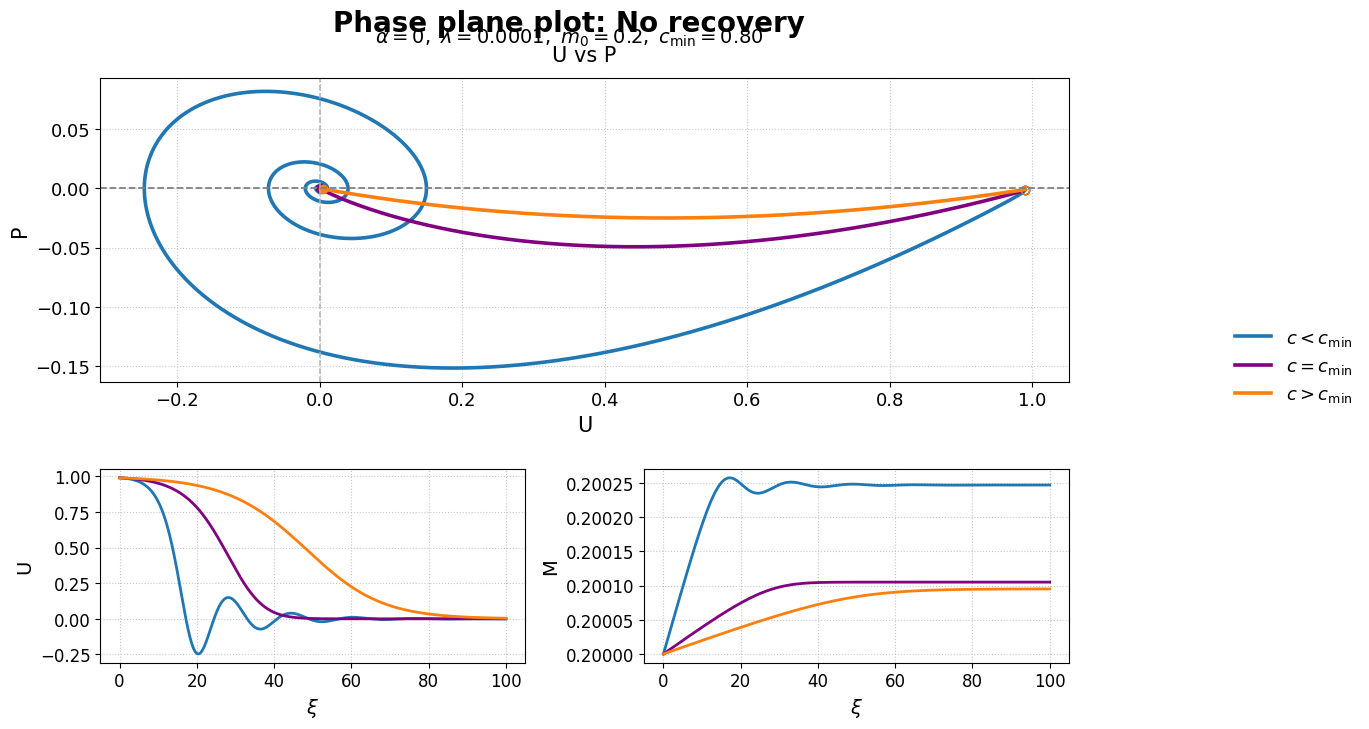

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
from scipy.integrate import solve_ivp

# =========================
# DESIGN system (y = [U,P,M])
# =========================
def rhs_design(z, X, c, lam, alpha):
    U, P, M = X
    D = M * (1.0 - M)
    dU = P
    dP = -c * P - U * (1.0 - U) * D
    dM = (D / c) * (lam * U * M - alpha * (1.0 - M))
    return [dU, dP, dM]

def make_stop_event_generic(blowU=5.0, blowP=5.0):
    def event(t, X, *args):
        U, P, M = X
        badM   = (M < -1e-6) or (M > 1.0 + 1e-6)
        blowUP = (not np.isfinite(U)) or (not np.isfinite(P)) or (abs(U) > blowU) or (abs(P) > blowP)
        return 0.0 if (badM or blowUP) else 1.0
    event.terminal  = True
    event.direction = 0
    return event

def integrate_and_plot(
    *, lam=1.0, alpha=0.0, m0=0.2,
    U0=0.99, P0=-0.01, M0=None,
    rel_speeds=(0.2, 1.0, 2.0),
    z_end=100.0, dz=0.01,
    rtol=1e-10, atol=1e-12, max_step=5e-3,
    proj=('U','P'), show=True
):
    if M0 is None:
        M0 = m0
    cmin = 2.0*np.sqrt(m0*(1.0-m0))
    c_list = [cmin*r for r in rel_speeds[:3]]
    labels = [r"$c<c_{\min}$", r"$c=c_{\min}$", r"$c>c_{\min}$"]
    colors = ["tab:blue","purple","tab:orange"]
    t_eval = np.arange(0.0, z_end+dz, dz)
    stop_evt = make_stop_event_generic()

    sols = []
    for c in c_list:
        sol = solve_ivp(
            rhs_design, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=stop_evt
        )
        sols.append(sol)

    # ---------- HERO LAYOUT ----------
    fig = plt.figure(figsize=(12.5, 7.6))
    gs  = GridSpec(2, 2, height_ratios=[2.2, 1.4], hspace=0.35, wspace=0.28)

    # Top: big phase-plane U–P
    ax_top = fig.add_subplot(gs[0, :])
    lines  = []
    for sol, col, lab in zip(sols, colors, labels):
        U, P = sol.y[0], sol.y[1]
        ln, = ax_top.plot(U, P, lw=2.6, color=col, label=lab)
        ax_top.plot(U[0],  P[0],  marker='o', ms=6, mfc='none', mec=col)
        ax_top.plot(U[-1], P[-1], marker='o', ms=6, mfc=col,   mec=col)
        lines.append(ln)
    ax_top.axhline(0, ls='--', lw=1.3, color='0.5')
    ax_top.axvline(0, ls='--', lw=1.1, color='0.7')
    ax_top.grid(True, ls=':', alpha=0.7)
    ax_top.set_xlabel("U", fontsize=15)
    ax_top.set_ylabel("P", fontsize=15)
    ax_top.tick_params(labelsize=13)
    ax_top.set_title("U vs P", pad=12, fontsize=15)

    # Bottom-left: U vs ξ
    ax_U = fig.add_subplot(gs[1, 0])
    for sol, col in zip(sols, colors):
        ax_U.plot(sol.t, sol.y[0], color=col, lw=2.0)
    ax_U.grid(True, ls=':', alpha=0.7)
    ax_U.set_xlabel(r"$\xi$", fontsize=14)
    ax_U.set_ylabel("U", fontsize=14)
    ax_U.tick_params(labelsize=12)
    ax_U.yaxis.set_major_locator(MaxNLocator(nbins=6))

    # Bottom-right: M vs ξ
    ax_M = fig.add_subplot(gs[1, 1], sharex=ax_U)
    for sol, col in zip(sols, colors):
        ax_M.plot(sol.t, sol.y[2], color=col, lw=2.0)
    ax_M.grid(True, ls=':', alpha=0.7)
    ax_M.set_xlabel(r"$\xi$", fontsize=14)
    ax_M.set_ylabel("M", fontsize=14)
    ax_M.tick_params(labelsize=12)
    ax_M.yaxis.set_major_locator(MaxNLocator(nbins=6))

    # Shared legend (RIGHT)
    fig.legend(lines, [ln.get_label() for ln in lines],
               loc="center left", bbox_to_anchor=(1.02, 0.5),
               frameon=False, fontsize=13)

    # Title + subtitle
    title = "Phase plane plot: " + ("No recovery" if alpha == 0 else "Recovery")
    fig.suptitle(title, y=0.97, fontsize=20, weight='bold')
    plt.figtext(
        0.5, 0.925,
        rf"$\alpha={alpha:g}, \ \lambda={lam:g}, \ m_0={m0:.3g}, \ c_{{\min}}={cmin:.2f}$",
        ha="center", fontsize=14
    )

    plt.tight_layout(rect=[0.02, 0.04, 0.86, 0.94])
    if show:
        plt.show()

    return {'cmin': cmin, 'c_list': c_list, 'solutions': sols}


# =========================
# CROSSLEY system (y = [U,V,M])
# =========================
def rhs_crossley(z, X, c, lam):
    U, V, M = X
    denom = max(1.0 - M, 1e-10)  # guard 1/(1-M)
    dU = V
    dV = (-c*V - (lam/c)*M*U*V - (lam**2/c**2)*M*U**3 - U*(1.0 - U - M)) / denom
    dM = (lam/c) * M * U
    return [dU, dV, dM]

def make_stop_event_crossley(eps=1e-6, blowU=5.0, blowV=5.0):
    def event(t, X, *args):
        U, V, M = X
        near_sing = (M > 1.0 - eps)  # avoid 1/(1-M) blow-up
        blowUP = (not np.isfinite(U)) or (not np.isfinite(V)) or (abs(U)>blowU) or (abs(V)>blowV)
        return 0.0 if (near_sing or blowUP) else 1.0
    event.terminal  = True
    event.direction = 0
    return event

def integrate_and_plot_crossley(
    *, lam=1.0, m0=0.01,
    U0=0.9, V0=-0.01, M0=None,
    speeds=None, z_end=100.0, dz=0.01,
    rtol=1e-12, atol=1e-15, max_step=5e-3,
    proj=('U','V'), show=True
):
    if M0 is None:
        M0 = m0
    # paper’s set if not provided
    if speeds is None:
        speeds = [1.0, 2.0*(1.0 - m0), 3.0]
    labels = [r"$c<c_{\min}$", r"$c=c_{\min}$", r"$c>c_{\min}$"]
    colors = ["tab:blue","purple","tab:orange"]
    t_eval = np.arange(0.0, z_end+dz, dz)
    stop_evt = make_stop_event_crossley()

    sols = []
    for c in speeds[:3]:
        sol = solve_ivp(
            rhs_crossley, (0.0, z_end), [U0, V0, M0],
            args=(c, lam),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=stop_evt
        )
        sols.append(sol)

    # reference c for labeling (paper convention)
    c_ref = 2.0*(1.0 - m0)

    # ---------- HERO LAYOUT ----------
    fig = plt.figure(figsize=(12.5, 7.6))
    gs  = GridSpec(2, 2, height_ratios=[2.2, 1.4], hspace=0.35, wspace=0.28)

    # Top: big phase-plane U–V
    ax_top = fig.add_subplot(gs[0, :])
    lines  = []
    for sol, col, lab in zip(sols, colors, labels):
        U, V = sol.y[0], sol.y[1]
        ln, = ax_top.plot(U, V, lw=2.6, color=col, label=lab)
        ax_top.plot(U[0],  V[0],  marker='o', ms=6, mfc='none', mec=col)
        ax_top.plot(U[-1], V[-1], marker='o', ms=6, mfc=col,   mec=col)
        lines.append(ln)
    ax_top.axhline(0, ls='--', lw=1.3, color='0.5')
    ax_top.axvline(0, ls='--', lw=1.1, color='0.7')
    ax_top.grid(True, ls=':', alpha=0.7)
    ax_top.set_xlabel("U", fontsize=15)
    ax_top.set_ylabel("V", fontsize=15)
    ax_top.tick_params(labelsize=13)
    ax_top.set_title("U vs V", pad=12, fontsize=15)

    # Bottom-left: U vs ξ
    ax_U = fig.add_subplot(gs[1, 0])
    for sol, col in zip(sols, colors):
        ax_U.plot(sol.t, sol.y[0], color=col, lw=2.0)
    ax_U.grid(True, ls=':', alpha=0.7)
    ax_U.set_xlabel(r"$\xi$", fontsize=14)
    ax_U.set_ylabel("U", fontsize=14)
    ax_U.tick_params(labelsize=12)
    ax_U.yaxis.set_major_locator(MaxNLocator(nbins=6))

    # Bottom-right: M vs ξ
    ax_M = fig.add_subplot(gs[1, 1], sharex=ax_U)
    for sol, col in zip(sols, colors):
        ax_M.plot(sol.t, sol.y[2], color=col, lw=2.0)
    ax_M.grid(True, ls=':', alpha=0.7)
    ax_M.set_xlabel(r"$\xi$", fontsize=14)
    ax_M.set_ylabel("M", fontsize=14)
    ax_M.tick_params(labelsize=12)
    ax_M.yaxis.set_major_locator(MaxNLocator(nbins=6))

    # Shared legend (RIGHT)
    fig.legend(lines, [ln.get_label() for ln in lines],
               loc="center left", bbox_to_anchor=(1.02, 0.5),
               frameon=False, fontsize=13)

    # Title + subtitle (paper-style c_ref)
    fig.suptitle("Phase plane plot", y=0.97, fontsize=20, weight='bold')
    plt.figtext(
        0.5, 0.925,
        rf"$m_0={m0:.3g}, \ \lambda={lam:g}, \ c_{{\rm ref}}=2(1-m_0)={c_ref:.2f}$",
        ha="center", fontsize=14
    )

    plt.tight_layout(rect=[0.02, 0.04, 0.86, 0.94])
    if show:
        plt.show()

    return {'speeds': speeds[:3], 'solutions': sols}


# =========================
# Example run (your alpha=0 case)
# =========================
if __name__ == "__main__":
    # Design-system figure-style run (alpha = 0)
    integrate_and_plot(
        lam=0.0001, alpha=0.0, m0=0.2,
        U0=0.99, P0=-0.001, M0=0.2,
        rel_speeds=(0.2, 1.0, 2.0),   # scales of c_min
        z_end=100.0, dz=0.01,
        rtol=1e-15, atol=1e-15, max_step=0.01,
        proj=('U','P')   # in design system the momentum variable is P
    )